In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack
import lib
np.random.seed(666)

Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion

Generate the 1D-DCT basis

In [3]:
DCT = lib.dct_matrix(M)

Generating the 1-D standard basis

In [4]:
C = np.eye(M)

Define the dictionary $D = [DCT, C]$

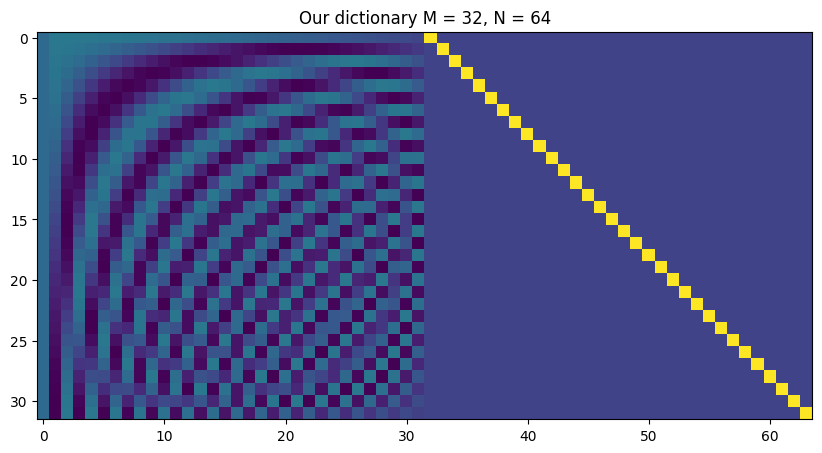

In [5]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}');

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [6]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

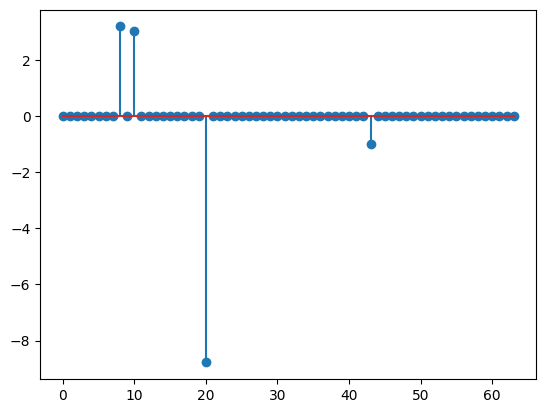

In [7]:
x0 = lib.Lsparse(N, L) * 5
x0[np.abs(x0) < 1] = np.sign(x0[np.abs(x0) < 1])
plt.stem(x0);

Choose spike location

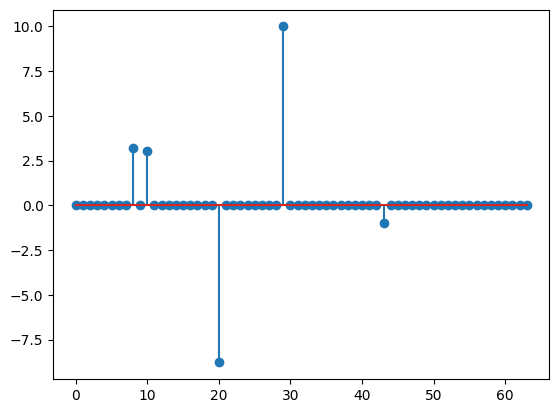

In [8]:
spikeLocation = np.random.choice(np.arange(N)[x0 == 0], 1).item()
x0[spikeLocation] = 10
plt.stem(x0);

Synthetize the corresponding signal in the signal domain and add noise


In [9]:
s0 = D @ x0
s = s0 + sigma_noise * np.random.randn(M)

Plot the sparse signal

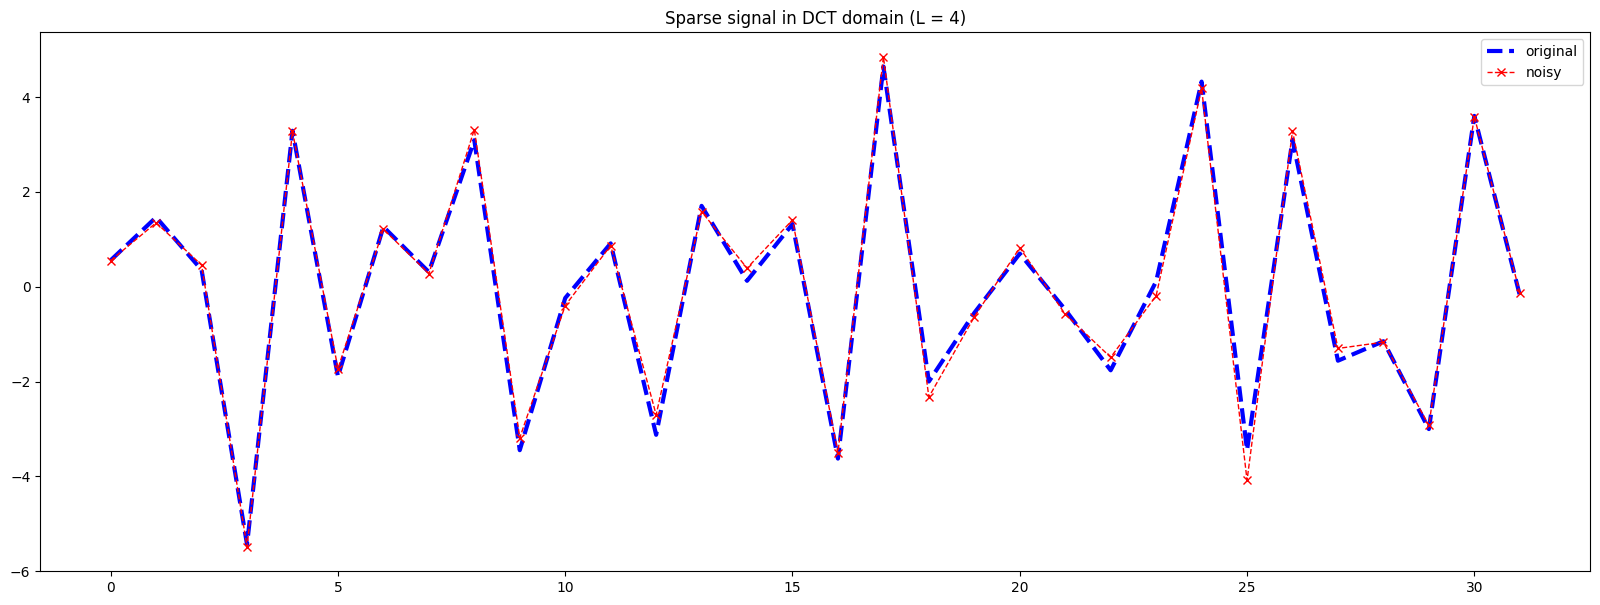

In [10]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(20, 7))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy']);

## Orthogonal Matching Pursuit

In [11]:
omp = lib.MatchingPursuit(L+1, mode=lib.MatchingPursuit.Mode.ORTHOGONAL, max_iter=1000)
x_OMP = omp.fit(D, s)
x_OMP.shape

(64,)

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [12]:
s_hat_OMP = D @ x_OMP

Show the result

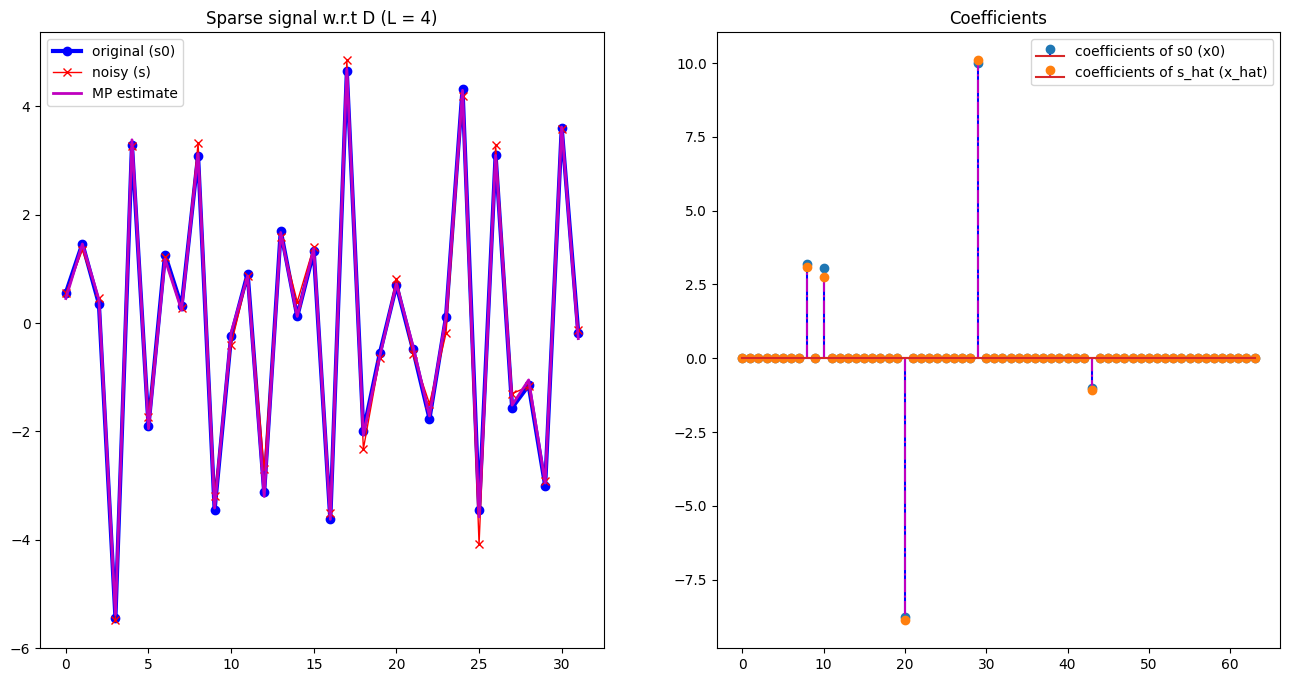

In [13]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)']);

## Least Squares Orthogonal Matching Pursuit

In [14]:
lsomp = lib.MatchingPursuit(L+1, mode=lib.MatchingPursuit.Mode.LEAST_SQUARES, max_iter=1000)
x_LSOMP = lsomp.fit(D, s)

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [15]:
s_hat_LSOMP = D @ x_LSOMP

Show the result

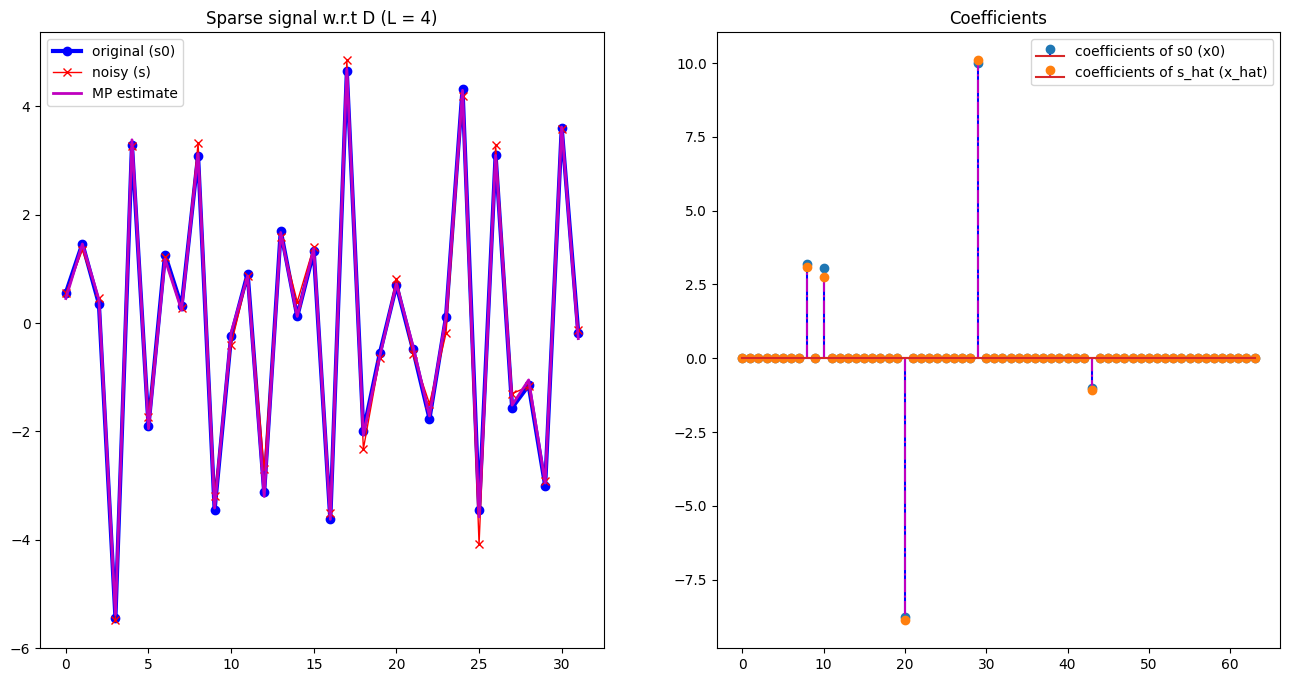

In [16]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)']);